# Damage exposure mismatch including unertainty quantification due to the random placement

This Notebook analyzes the mismatch between damage and exposure dataset. It also quantifies uncertainties related to the random placement of about 25% of damage claims without exact coordinate. It uses 1000 resamples of the randomly placed damage, i.e. 1000 slightly different damage datasets, for wheat and grapevine. This allows, providing a Confidence Intervals for FAR, POD, and HSS. It also produces a plot showing the fraction of grid cells with damage that have no exposure or the fraction of grid cells that have more damage than exposure, including uncertainty estimates (in a boxplot). The Figure is not used for the manuscript, but some of the numbers behind it are noted. 

In [1]:
import sys, os
#change path to path of current skript, where also utility.py lies
sys.path.append('C:/Users/F80840370/projects/scClim/climada/scClim/subproj_D/papers/NHESS/code_and_data/')
import matplotlib.pyplot as plt
import numpy as np
import matplotlib 
from climada import CONFIG
import re

from matplotlib.legend_handler import HandlerTuple
from utility import data_dir, read_at_centroid_data, compute_verification_stats


Define some useful functions

In [2]:
#%% handy functions
def prep_monte_carlo_samples(at_centroid_data, resolutions, get_years=None):
    
    f_mc_no_exp={r: [] for r in resolutions}
    f_mc_larger_exp={r: [] for r in resolutions}
    for data_n in at_centroid_data:
        for res in resolutions:
            data=data_n[res]
            
            if get_years is not None:
                datelist=[d for d in list(set(data['date'])) if d.year in get_years]
            else:
                datelist=list(set(data['date']))
            data=data[data['date'].isin(datelist)]
            
            n_dmg_without_exp=len(data[(data['n_exp'].fillna(0)==0) & (data['n_dmgs']>0)])
            n_dmg_larger_exp=len(data[(data['n_exp'].fillna(0)<data['n_dmgs'])])
            n_centroids_with_dmg = len(data[data['n_dmgs']>0])
            
            f_mc_no_exp[res].append(n_dmg_without_exp / n_centroids_with_dmg)
            f_mc_larger_exp[res].append(n_dmg_larger_exp / n_centroids_with_dmg)
    
    return f_mc_no_exp, f_mc_larger_exp

def prep_orig_data(at_centroid_data_orig, resolutions, get_years=None):
    #prep data
    f_dmg_no_exp =[]
    f_dmg_larger_exp=[]
    n_exp_dmgs=[]
    for res in resolutions:
        data=at_centroid_data_orig[res]
        if get_years is not None:
            datelist=[d for d in list(set(data['date'])) if d.year in get_years]
        else:
            datelist=list(set(data['date']))
        data=data[data['date'].isin(datelist)]
        n_dmg_without_exp=len(data[(data['n_exp'].fillna(0)==0) & (data['n_dmgs']>0)])
        n_dmg_larger_exp=len(data[(data['n_exp'].fillna(0)<data['n_dmgs'])])
        n_centroids_with_dmg = len(data[data['n_dmgs']>0])
        
        n_exp_dmgs.append(data[data['n_dmgs']>0]['n_exp'].sum())
        f_dmg_no_exp.append(n_dmg_without_exp / n_centroids_with_dmg)
        f_dmg_larger_exp.append(n_dmg_larger_exp / n_centroids_with_dmg)

        n_dates=len(datelist)
        
    return f_dmg_no_exp, f_dmg_larger_exp, n_dates, n_exp_dmgs
    
def plot_damage_exposure_mismatch(ax, f_dmg_no_exp, f_dmg_larger_exp,n_exp_dmgs, f_mc_no_exp, f_mc_larger_exp, resolutions):
 
    names=['more damaged \n than exposed \n fields',
           '','',
           'damaged but \n no exposed \n fields']
  
    box1=ax.boxplot([f_mc_larger_exp[km] for km in f_mc_larger_exp.keys()],patch_artist=True,medianprops=dict(color='k'),boxprops=dict(facecolor='mistyrose'))  
    box2=ax.boxplot([f_mc_no_exp[km] for km in f_mc_no_exp.keys()],patch_artist=True,medianprops=dict(color='k'),boxprops=dict(facecolor='lightblue'))  
    x=[1,2,3]
    h1=ax.scatter(x,f_dmg_larger_exp, color='r', s=300, marker='d', edgecolors='k', label = names[0],zorder=10)  
    h2=ax.scatter(x,f_dmg_no_exp, color = 'blue',s=300, marker='*',edgecolors='k', label = names[1],zorder=10) 
    h3=ax.scatter(1,0.5, color = 'none')
    
    frac=np.round(np.array(n_exp_dmgs)/n_exp_dmgs[0]*100)
    
    #for k,xx in enumerate(x):
    #    ax.text(xx,0.3,f'{int(n_exp_dmgs[k])}\n({int(frac[k])}%)',ha='center',fontsize=15)
        
    handles=[(h1,box1['boxes'][0]),(h3, h3),(h3, h3),(h2,box2['boxes'][0])]
    

    
    return handles,names

Define directories

In [3]:
#%% directories
datadir = f"{data_dir}/data_at_centroid/"
figdir = 'C:/Users/F80840370/projects/scClim/climada/scClim/subproj_D/papers/NHESS/fig/'
variable='MESHS'

read at centroid data for wheat and grapevine

In [8]:
at_centroid_data_orig={}
croptype_lists= [['Weizen'],['Reben']]
#get original data
for croptypes in croptype_lists:
    data, croptype = read_at_centroid_data(datadir,croptypes,variable=variable)
    at_centroid_data_orig[croptype]=data


read at centroid data for all crops

In [4]:
at_centroid_data_orig_2={}    
croptypes_2=[['Weizen','Mais','Gerste','Raps'],['Mais'],['Gerste'],['Raps'],['Reben'],['Weizen']]
for c in croptypes_2:
    data, ct = read_at_centroid_data(f'{datadir}/data_at_centroid/',c,variable=variable)
    at_centroid_data_orig_2[ct]=data

Print the fraction of grid cells without and with more damaged than exposed fields for different resolutions

In [12]:
croptype='Gerste'
resolutions=['1km','2km','4km']
f_dmg_no_exp, f_dmg_larger_exp, n_dat,n_exp_dmgs = prep_orig_data(at_centroid_data_orig_2[croptype], resolutions) 
print(croptype)
print('resolutions:', resolutions)
print('Fraction of damage grid cells without exposure:\n',f_dmg_no_exp)
print('Fraction of damage grid cells with more damaged than exposed fields:\n',f_dmg_no_exp)


Gerste
resolutions: ['1km', '2km', '4km']
Fraction of damage grid cells without exposure:
 [0.09398756046993781, 0.020856201975850714, 0.00597609561752988]
Fraction of damage grid cells with more damaged than exposed fields:
 [0.09398756046993781, 0.020856201975850714, 0.00597609561752988]


Get at centroid data from monte carlo samples for wheat and grapevine

In [10]:
#%% get data from montecarlo samples
at_centroid_data_mc={c[0]: [] for c in croptype_lists}
for croptypes in croptype_lists:
    croptype=croptypes[0]
    if croptype=='Reben':
        mc_files=[file for file in os.listdir(f'{datadir}/MonteCarlo/') if file.startswith(f'values_at_centroid_{variable}_1_2_4_8km_{croptype}')]
    else:
        mc_files=[file for file in os.listdir(f'{datadir}/MonteCarlo/') if file.startswith(f'values_at_centroid_{variable}_1_2_4_8km_{croptype}')]

    for mc_file in mc_files: 
        sample_id = re.findall('[0-9]+', mc_file)[-1]
        at_centroid_data_n, _ = read_at_centroid_data(f'{datadir}/MonteCarlo/',croptypes,variable=variable, sample_id=sample_id)
        at_centroid_data_mc[croptype].append(at_centroid_data_n)

quantify 95% confidence interval

In [24]:
fars=[]
pods=[]
hss=[]
for data in at_centroid_data_mc['Weizen']:
    df, npred = compute_verification_stats(data['1km'],
                                                variable = variable,
                                                exposure_thresh=1)
    fars.append(df.loc[40]['FAR'])
    pods.append(df.loc[40]['POD'])
    hss.append(df.loc[40]['HSS'])


In [26]:
qs=[0.025,0.975]
print(f'FAR CI:{np.diff(np.quantile(fars,q=qs))}')
print(f'POD CI:{np.diff(np.quantile(pods,q=qs))}')
print(f'HSS CI:{np.diff(np.quantile(hss,q=qs))}')

FAR CI:[0.00729121]
POD CI:[0.01118825]
HSS CI:[0.00888628]


Prepare data for final plot (takes a long time)

In [13]:
#%% Plot damage exposure mismatches

#prepare data
resolutions=['1km','2km','4km']
get_years=[[2017,2018,2019,2020],[2021]]
mc_data={c[0]: [] for c in croptype_lists}
orig_data={c[0]: [] for c in croptype_lists}
n_dates={c[0]: [] for c in croptype_lists}
n_dates_crops={c: [] for c in at_centroid_data_orig_2.keys()}
orig_data_2={c: [] for c in at_centroid_data_orig_2.keys()}

#
for croptypes in croptype_lists:
    croptype=croptypes[0]
    print(croptype)
    for i,yearlist in enumerate(get_years):
        f_mc_no_exp, f_mc_larger_exp = prep_monte_carlo_samples(at_centroid_data_mc[croptype], resolutions, get_years=yearlist)
        f_dmg_no_exp, f_dmg_larger_exp, n_dat,n_exp_dmgs = prep_orig_data(at_centroid_data_orig[croptype], resolutions, get_years=yearlist) 
        mc_data[croptype].append([f_mc_no_exp, f_mc_larger_exp])
        orig_data[croptype].append([f_dmg_no_exp, f_dmg_larger_exp,n_exp_dmgs])
        n_dates[croptype].append(n_dat)
        for c in at_centroid_data_orig_2.keys():
            f_dmg_no_exp, f_dmg_larger_exp, n_dat, n_exp_dmgs = prep_orig_data(at_centroid_data_orig_2[c], resolutions, get_years=yearlist) 
            orig_data_2[c].append([f_dmg_no_exp, f_dmg_larger_exp])
            n_dates_crops[c].append(n_dat)

Weizen
Reben


Produce final plot

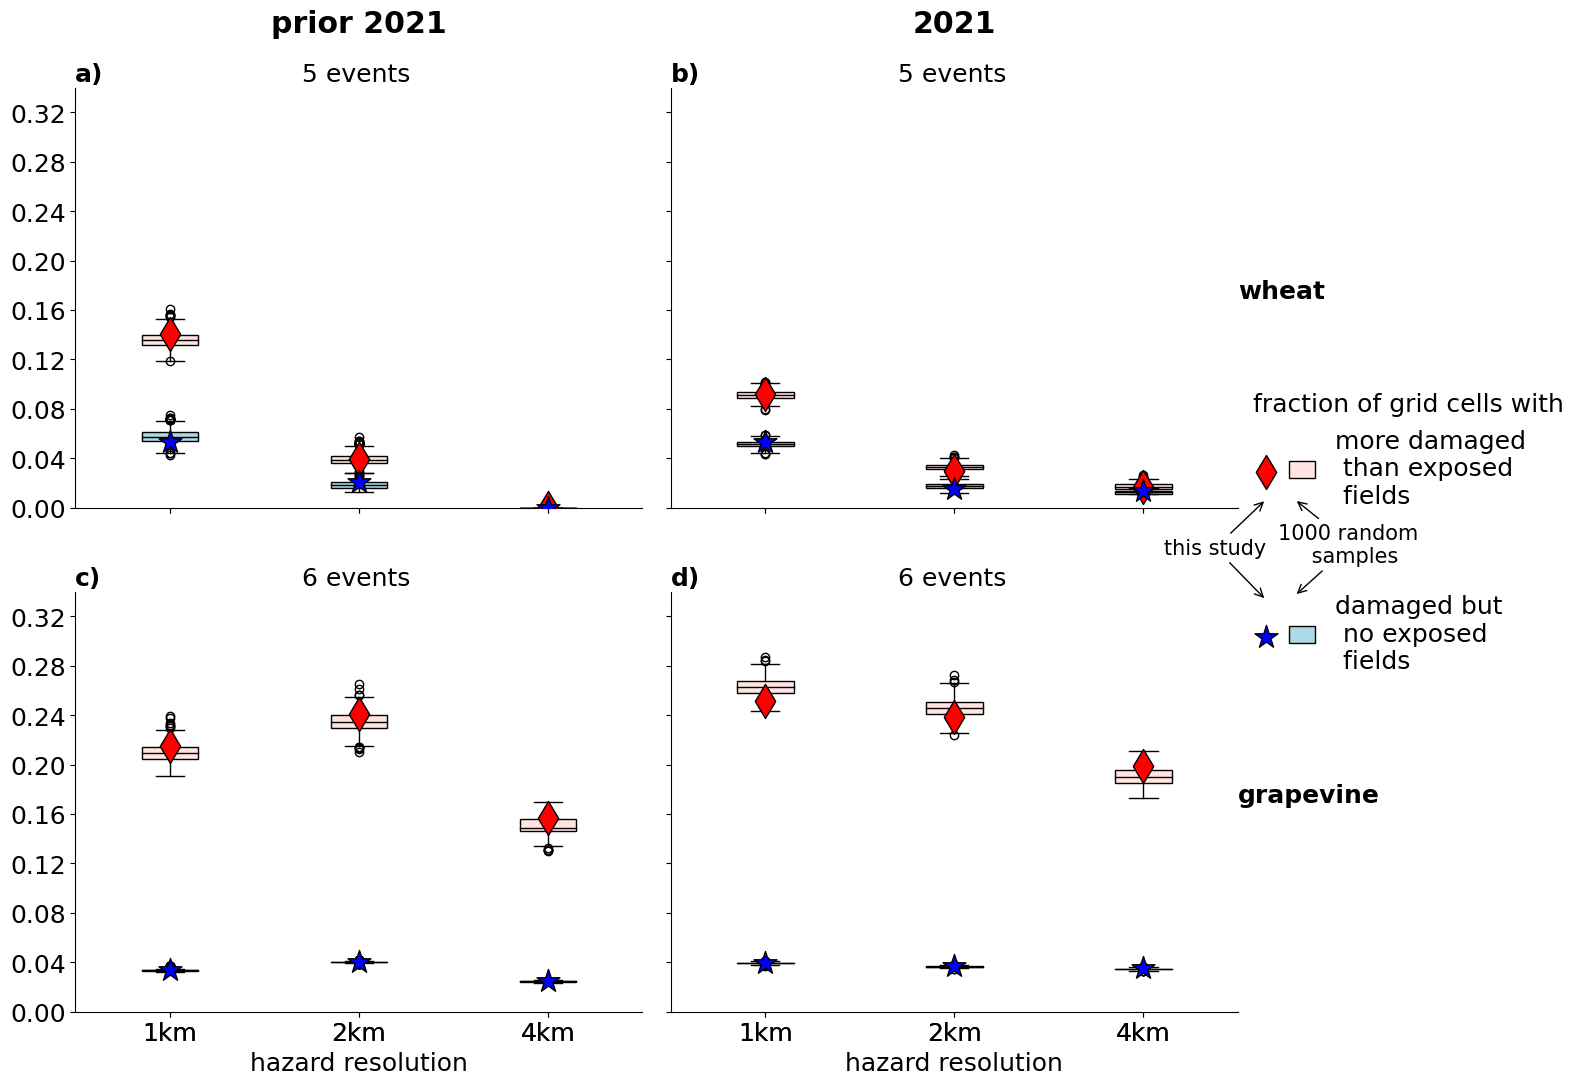

In [15]:
#%%Plot
titles=['prior 2021','2021']
labels=['a)','b)','c)','d)']
cropnames=['wheat','grapevine']
fig, axes = plt.subplots(2,2,figsize=(15,12),sharey=True)
axs=axes.flatten()
matplotlib.rcParams.update({'font.size': 18,
                            'axes.labelsize': 18})
bboxx=1.3
bboxy=0.56

#loop over croptypes
for j,croptype in enumerate(orig_data.keys()):
    for i,_ in enumerate(get_years):
        ax=axes[j,i]
        handles,names=plot_damage_exposure_mismatch(ax, orig_data[croptype][i][0], orig_data[croptype][i][1], orig_data[croptype][i][2], mc_data[croptype][i][0], mc_data[croptype][i][1], resolutions)                                          
            
        if j==1:
            ax.set_xticklabels(resolutions+resolutions)    
            ax.set_xlabel('hazard resolution')
        elif j==0:
            ax.set_xticklabels([])
            ax.set_title(f'{titles[i]}',fontweight='bold',pad=40)
        ax.spines[['right', 'top']].set_visible(False)
        ax.text(0,1.015,labels[2*j+i],
                    transform=ax.transAxes,fontweight='bold')
        ax.text(0.4,1.015,f'{n_dates[croptype][i]} events',
                    transform=ax.transAxes)
        if i==1:
            ax.text(1,0.5,cropnames[j],
                    transform=ax.transAxes,fontweight='bold')

ax=axes[0,1]
leg=ax.legend(handles=handles,labels=names,handlelength=2.5,handler_map={tuple: HandlerTuple(ndivide=2)},ncol=1,loc='center',title='fraction of grid cells with', bbox_to_anchor=(bboxx,0.5-bboxy),edgecolor='none')
leg._legend_box.align = "left"
fs=15
ast="->"
ax.annotate("this study", xy=(bboxx-0.25, 0.58-bboxy),xytext=(bboxx-0.43, 0.45-bboxy),arrowprops=dict(arrowstyle=ast,color='k'), xycoords=ax.transAxes,zorder=10,color='w',fontsize=fs)
ax.annotate("this study", xy=(bboxx-0.25, 0.34-bboxy),xytext=(bboxx-0.43, 0.45-bboxy),arrowprops=dict(arrowstyle=ast,color='k'), xycoords=ax.transAxes,zorder=10,fontsize=fs)
ax.annotate("1000 random \n samples", xy=(bboxx-0.2, 0.58-bboxy),xytext=(bboxx-0.1, 0.43-bboxy),arrowprops=dict(arrowstyle=ast,color='k'), xycoords=ax.transAxes,zorder=10,color='w',fontsize=fs,ha='center')
ax.annotate("1000 random \n samples", xy=(bboxx-0.2, 0.35-bboxy),xytext=(bboxx-0.1, 0.43-bboxy),arrowprops=dict(arrowstyle=ast,color='k'), xycoords=ax.transAxes,zorder=10,fontsize=fs,ha='center')
plt.subplots_adjust(hspace=0.2,wspace=0.05)

## only if want to plot all other cps
# orig_data_2['field crops']=orig_data_2['Weizen_Mais_Gerste_Raps']
# for i,_ in enumerate(get_years):
#     ax=axs[2+i]
#     for c in ['Reben']:
#         if c=='Reben':
#             name='grapevine'
#         h0=ax.scatter([1,2,3],orig_data_2[c][i][0],color = 'blue',s=300, marker='*',edgecolors='k', label = name,zorder=10,alpha=1)
#         h1=ax.scatter([1,2,3],orig_data_2[c][i][1],color = 'r',s=300, marker='d',edgecolors='k', label = name,zorder=10,alpha=1)
#     ax.text(0,1.015,labels[2+i],
#                     transform=ax.transAxes,fontweight='bold')
ax.set_ylim([0,0.34])
ax.set_yticks(np.arange(0,0.34,0.04))
  

Save Figure

In [16]:
figname='Figure_0'
fig.savefig(f'{figdir}/{figname}_1_2_4km.png',dpi=300,bbox_inches='tight')
fig.savefig(f'{figdir}/{figname}_1_2_4km.pdf',dpi=300,bbox_inches='tight')


Get fraction of damage claims outside exposure

In [17]:
for croptype in at_centroid_data_orig_2.keys():
    data=at_centroid_data_orig_2[croptype]
    for res in data.keys():
        no_exp=data[res][data[res]['n_exp'].fillna(0)==0]['n_dmgs'].sum()
        all=data[res]['n_dmgs'].sum()
        print(croptype,res,no_exp/all)

Weizen_Mais_Gerste_Raps 1km 0.00531475138774064
Weizen_Mais_Gerste_Raps 2km 0.0008857918979567733
Weizen_Mais_Gerste_Raps 4km 0.00035431675918270935
Weizen_Mais_Gerste_Raps 8km 0.0
Weizen_Mais_Gerste_Raps 16km 0.0
Weizen_Mais_Gerste_Raps 32km 0.0
Mais 1km 0.021120563215019067
Mais 2km 0.0026400704018773834
Mais 4km 0.0005866823115283074
Mais 8km 0.0
Mais 16km 0.0
Mais 32km 0.0
Gerste 1km 0.07378190255220418
Gerste 2km 0.00974477958236659
Gerste 4km 0.0013921113689095127
Gerste 8km 0.0
Gerste 16km 0.0
Gerste 32km 0.0
Raps 1km 0.10564454614797865
Raps 2km 0.018688024408848206
Raps 4km 0.004958047292143402
Raps 8km 0.00038138825324180017
Raps 16km 0.00038138825324180017
Raps 32km 0.0
Reben 1km 0.00436029833620195
Reben 2km 0.002294893861158921
Reben 4km 0.0012621916236374069
Reben 8km 0.0009179575444635686
Reben 16km 0.0
Reben 32km 0.0
Aepfel 1km 0.512280701754386
Aepfel 2km 0.33157894736842103
Aepfel 4km 0.20701754385964913
Aepfel 8km 0.13157894736842105
Aepfel 16km 0.12456140350877193
A

Now, show these same numbers but only for claims in 2021

In [28]:
for croptype in at_centroid_data_orig_2.keys():
    
    for res in at_centroid_data_orig_2[croptype].keys():
        data=at_centroid_data_orig_2[croptype][res]
        datelist=[d for d in list(set(data['date'])) if d.year in [2021]]
        data=data[data['date'].isin(datelist)]
        no_exp=data[data['n_exp'].fillna(0)==0]['n_dmgs'].sum()
        all=data['n_dmgs'].sum()
        print(croptype,res,no_exp/all)

Weizen_Mais_Gerste_Raps 1km 0.003453379378391712
Weizen_Mais_Gerste_Raps 2km 0.000657786548265088
Weizen_Mais_Gerste_Raps 4km 0.000493339911198816
Weizen_Mais_Gerste_Raps 8km 0.0
Weizen_Mais_Gerste_Raps 16km 0.0
Weizen_Mais_Gerste_Raps 32km 0.0
Mais 1km 0.014460285132382893
Mais 2km 0.0018329938900203666
Mais 4km 0.000814663951120163
Mais 8km 0.0
Mais 16km 0.0
Mais 32km 0.0
Gerste 1km 0.06052193225985564
Gerste 2km 0.009994447529150472
Gerste 4km 0.001665741254858412
Gerste 8km 0.0
Gerste 16km 0.0
Gerste 32km 0.0
Raps 1km 0.08374083129584352
Raps 2km 0.017726161369193152
Raps 4km 0.003667481662591687
Raps 8km 0.0006112469437652812
Raps 16km 0.0006112469437652812
Raps 32km 0.0
Reben 1km 0.005434782608695652
Reben 2km 0.002717391304347826
Reben 4km 0.0017292490118577075
Reben 8km 0.0014822134387351778
Reben 16km 0.0
Reben 32km 0.0
Aepfel 1km 0.5046511627906977
Aepfel 2km 0.3372093023255814
Aepfel 4km 0.19534883720930232
Aepfel 8km 0.10697674418604651
Aepfel 16km 0.1
Aepfel 32km 0.0627906

In [27]:
res

'n_exp'

In [23]:
data.keys()

Index(['n_exp', 'n_dmgs', 'MESHS', 'PAA', 'date'], dtype='object')

In [20]:
data

{'1km':                      n_exp  n_dmgs  MESHS  PAA       date
 centr_HL date                                            
 168026   2017-06-27    1.0     0.0   21.0  NaN 2017-06-27
          2017-07-08    1.0     0.0    0.0  NaN 2017-07-08
          2017-08-01    1.0     0.0    0.0  NaN 2017-08-01
          2019-06-15    1.0     0.0    0.0  NaN 2019-06-15
          2019-06-30    1.0     0.0    0.0  NaN 2019-06-30
 ...                    ...     ...    ...  ...        ...
 325619   2021-06-20    3.0     0.0    0.0  NaN 2021-06-20
          2021-06-21    3.0     0.0    0.0  NaN 2021-06-21
          2021-06-28    3.0     0.0    0.0  NaN 2021-06-28
          2021-07-12    3.0     0.0    0.0  NaN 2021-07-12
          2021-07-24    3.0     0.0    0.0  NaN 2021-07-24
 
 [149155 rows x 5 columns],
 '2km':                      n_exp  n_dmgs  MESHS  PAA       date
 centr_HL date                                            
 37052    2017-06-27    2.0     0.0    0.0  NaN 2017-06-27
          20

Or the fraction of grid cells with damage that have zero exposure

In [14]:
for croptype in at_centroid_data_orig_2.keys():
    for res in at_centroid_data_orig_2[croptype].keys():
        data=at_centroid_data_orig_2[croptype][res]
        n_dmg_without_exp=len(data[(data['n_exp'].fillna(0)==0) & (data['n_dmgs']>0)])
        n_dmg_larger_exp=len(data[(data['n_exp'].fillna(0)<data['n_dmgs'])])
        n_centroids_with_dmg = len(data[data['n_dmgs']>0])
        print(croptype,res,n_dmg_without_exp/n_centroids_with_dmg)

Weizen_Mais_Gerste_Raps 1km 0.015201715065289417
Weizen_Mais_Gerste_Raps 2km 0.004782781984854523
Weizen_Mais_Gerste_Raps 4km 0.0033585222502099076
Weizen_Mais_Gerste_Raps 8km 0.0
Weizen_Mais_Gerste_Raps 16km 0.0
Weizen_Mais_Gerste_Raps 32km 0.0
Mais 1km 0.03519604816301328
Mais 2km 0.008115942028985508
Mais 4km 0.0023121387283236996
Mais 8km 0.0
Mais 16km 0.0
Mais 32km 0.0
Gerste 1km 0.09398756046993781
Gerste 2km 0.020856201975850714
Gerste 4km 0.00597609561752988
Gerste 8km 0.0
Gerste 16km 0.0
Gerste 32km 0.0
Raps 1km 0.13431986340352875
Raps 2km 0.036155202821869487
Raps 4km 0.019966722129783693
Raps 8km 0.0030959752321981426
Raps 16km 0.005917159763313609
Raps 32km 0.0
Reben 1km 0.036603221083455345
Reben 2km 0.03836930455635491
Reben 4km 0.030534351145038167
Reben 8km 0.024539877300613498
Reben 16km 0.0
Reben 32km 0.0
Aepfel 1km 0.5934426229508196
Aepfel 2km 0.45622119815668205
Aepfel 4km 0.3051948051948052
Aepfel 8km 0.22115384615384615
Aepfel 16km 0.21428571428571427
Aepfel 32k

In [16]:
data=at_centroid_data_orig_2['Weizen']['1km']
data[(data['n_exp'].fillna(0)==0) & (data['n_dmgs']>0)]
#n_dmg_without_exp=len(data[(data['n_exp'].fillna(0)==0) & (data['n_dmgs']>0)])

,PAA,MDR,MESHS,n_exp,n_dmgs,exp_val,dmg_val,date,PVA,MDD,centr_HL
1017,NaN,NaN,21.0,NaN,1.0,NaN,0.238919,2017-06-27,NaN,0.15,228200
1055,NaN,NaN,24.0,NaN,1.0,NaN,0.079640,2017-06-27,NaN,0.05,228910
1092,NaN,NaN,25.0,NaN,1.0,NaN,0.095568,2017-06-27,NaN,0.06,229620
3100,NaN,NaN,0.0,NaN,1.0,NaN,0.238919,2017-06-27,NaN,0.15,254465
3860,NaN,NaN,0.0,NaN,1.0,NaN,0.095568,2017-06-27,NaN,0.06,264484
...,...,...,...,...,...,...,...,...,...,...,...
91108,NaN,NaN,0.0,NaN,1.0,NaN,0.063712,2021-07-24,NaN,0.04,265899
91451,NaN,NaN,0.0,NaN,1.0,NaN,0.079640,2021-07-24,NaN,0.05,269458
91488,NaN,NaN,0.0,NaN,1.0,NaN,0.525622,2021-07-24,NaN,0.33,269559
91911,NaN,NaN,0.0,NaN,1.0,NaN,0.095568,2021-07-24,NaN,0.06,273733
